In [21]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from data_aug import load_images, tf_resize_images, central_scale_images, flip_images, get_translate_parameters, translate_images, rotate_images, add_gaussian_noise, add_salt_pepper_noise

In [23]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [24]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\vidia\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'la

In [25]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [26]:

first_sample = next(iter(dataset['test'].take(3)))  # Extract first sample
second_sample = next(iter(dataset['test'].take(50)))

# Access individual attributes
image =first_sample['image']    # Extract image tensor
image2 = second_sample['image']   # Extract image tensor

image_expanded = tf.expand_dims(image, axis=0)
image2_expanded = tf.expand_dims(image2, axis=0)

# Concatenate the two tensors along the new dimension (axis 0)
concatenated_image = tf.concat([image_expanded, image2_expanded], axis=0)

image_resized = tf_resize_images(concatenated_image,128,3)
print(image_resized[1])

tf.Tensor(
[[[250 241 232]
  [255 247 238]
  [251 244 234]
  ...
  [254 244 234]
  [254 244 234]
  [254 244 234]]

 [[251 242 233]
  [249 240 231]
  [249 242 232]
  ...
  [253 243 233]
  [253 243 233]
  [253 243 233]]

 [[251 242 233]
  [249 240 231]
  [249 242 232]
  ...
  [253 243 233]
  [253 243 233]
  [253 243 233]]

 ...

 [[158 159  55]
  [132 140  54]
  [139 150  72]
  ...
  [ 83 105  32]
  [ 87 109  34]
  [105 128  46]]

 [[157 163  57]
  [152 157  65]
  [139 144  60]
  ...
  [ 92 111  32]
  [ 96 113  33]
  [111 129  45]]

 [[145 154  47]
  [166 168  71]
  [153 153  65]
  ...
  [105 120  39]
  [107 122  37]
  [120 134  47]]], shape=(500, 403, 3), dtype=uint8)
tf.Tensor(
[[[250 241 232]
  [255 247 238]
  [251 244 234]
  ...
  [254 244 234]
  [254 244 234]
  [254 244 234]]

 [[251 242 233]
  [249 240 231]
  [249 242 232]
  ...
  [253 243 233]
  [253 243 233]
  [253 243 233]]

 [[251 242 233]
  [249 240 231]
  [249 242 232]
  ...
  [253 243 233]
  [253 243 233]
  [253 243 233]]

 

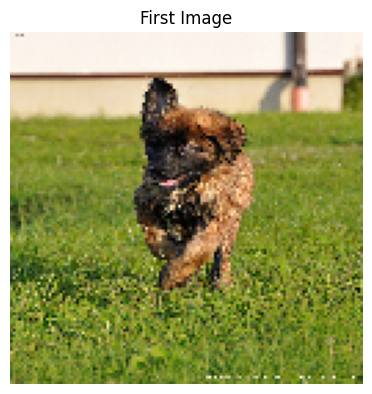

In [27]:
# Display the images
plt.figure(figsize=(10, 5))

# Plot first image
plt.subplot(1, 2, 1)
plt.imshow(image_resized[0].astype("uint8"))  # Remove .numpy() here
plt.title("First Image")
plt.axis('off')

'''
# Plot second image
plt.subplot(1, 2, 2)
plt.imshow(image_resized[1].astype("uint8"))  # Remove .numpy() here
plt.title("Second Image")
plt.axis('off')
'''

plt.show()

In [28]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (256,256))
  mask = tf.image.resize(data['segmentation_mask'], (256,256))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [29]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [30]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [31]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [32]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [33]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

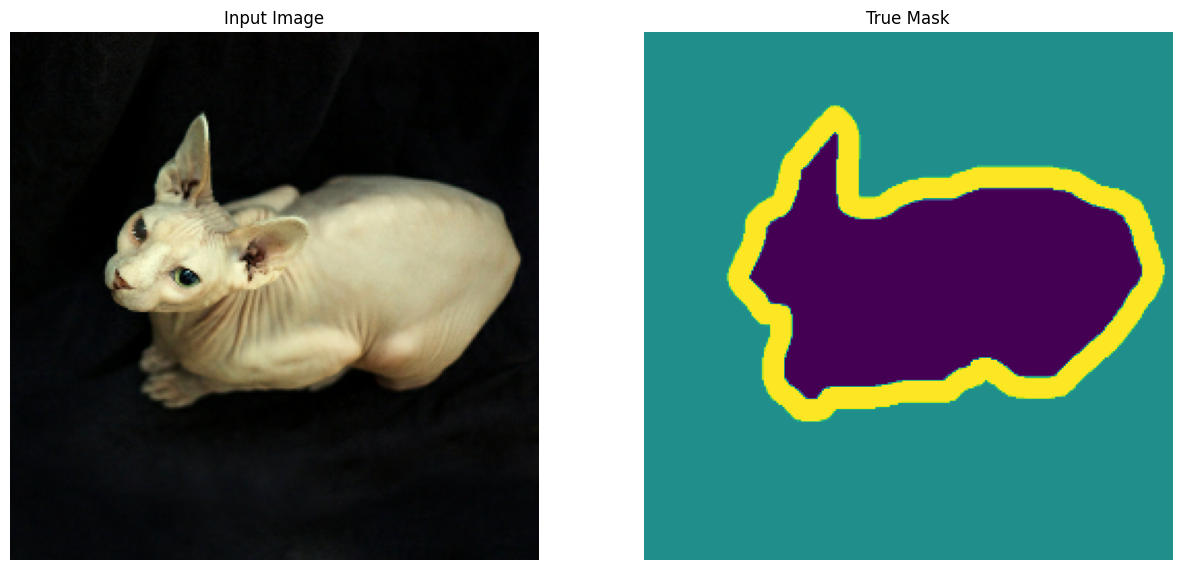

In [59]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])